# Обучение с учителем: качество модели

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Описание данных**

`market_file.csv`

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (**целевой признак**): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

`market_time.csv`

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv`

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

**Инструкция по выполнению проекта**

1. Разработайте модель, которая предскажет вероятность снижения покупательской активности.
2. Выделите сегмент покупателей, проанализируйте его и предложите, как увеличить его покупательскую активность. Используйте данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию вы можете проанализировать больше одного сегмента:
     
- Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
- Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
- Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
- Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [ ]:
!pip install -U scikit-learn
!pip install phik -q
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
#import phik
import scipy.stats #, math

from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression #, LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
#, r2_score, accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler #, LabelEncoder, RobustScaler
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Загрузка данных

In [ ]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv('C:/Users/Student/Desktop/market_file.csv')
    market_money = pd.read_csv('C:/Users/Student/Desktop/market_money.csv', sep=',')
    market_time = pd.read_csv('C:/Users/Student/Desktop/market_time.csv', sep=',')
    money = pd.read_csv('C:/Users/Student/Desktop/money.csv', sep=';', decimal=',')

In [ ]:
def dfinfo(df):
    df.info()
    display(df.head())

dfinfo(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В датасете `market_file` 1300 строк, пропусков нет.

In [ ]:
dfinfo(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


В датасете `market_money` 3900 строк (по 3 на каждый id), пропусков нет.

In [ ]:
dfinfo(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


В датасете `market_time` 2600 строк (по 2 на каждый id), пропусков нет.

In [ ]:
dfinfo(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


В датасете `money` 1300 строк (как и в `market_file`), пропусков нет.

Данные во всех 4 таблицах соответствуют описанию.

##  Предобработка данных

In [ ]:
def predobr(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    print('Пропуски:')
    print(df.isna().sum())
    print('Дубликатов', df.duplicated().sum())
    if df.duplicated().sum()>0:
        df = df.drop_duplicates().reset_index(drop=True)
        print('Дубликатов после удаления', df.duplicated().sum())

predobr(market_file)

Пропуски:
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
Дубликатов 0


In [ ]:
predobr(market_money)

Пропуски:
id         0
период     0
выручка    0
dtype: int64
Дубликатов 0


In [ ]:
predobr(market_time)

Пропуски:
id        0
период    0
минут     0
dtype: int64
Дубликатов 0


In [ ]:
predobr(money)

Пропуски:
id         0
прибыль    0
dtype: int64
Дубликатов 0


In [ ]:
market_file['покупательская_активность'].sort_values().unique()

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [ ]:
market_file['тип_сервиса'].sort_values().unique()

array(['премиум', 'стандарт', 'стандартт'], dtype=object)

In [ ]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
market_file['тип_сервиса'].sort_values().unique()

array(['премиум', 'стандарт'], dtype=object)

In [ ]:
market_file['разрешить_сообщать'].sort_values().unique()

array(['да', 'нет'], dtype=object)

In [ ]:
market_file['популярная_категория'].sort_values().unique()

array(['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника',
       'Техника для красоты и здоровья', 'Товары для детей'], dtype=object)

In [ ]:
market_money['период'].sort_values().unique()

array(['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'],
      dtype=object)

In [ ]:
market_time['период'].sort_values().unique()

array(['предыдцщий_месяц', 'текущий_месяц'], dtype=object)

In [ ]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].sort_values().unique()

array(['предыдущий_месяц', 'текущий_месяц'], dtype=object)

В датасетах переименовали столбцы: сделали названия в нижнем регистре и заменили пробел знаком _.

Пропусков и явных дубликатов нет.

Устранили неявные дубликаты в `market_file` - `тип_сервиса`, также в `market_time` - `период` исправлена опечатка.

## Исследовательский анализ данных

### Анализ количественных признаков для `market_file`

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


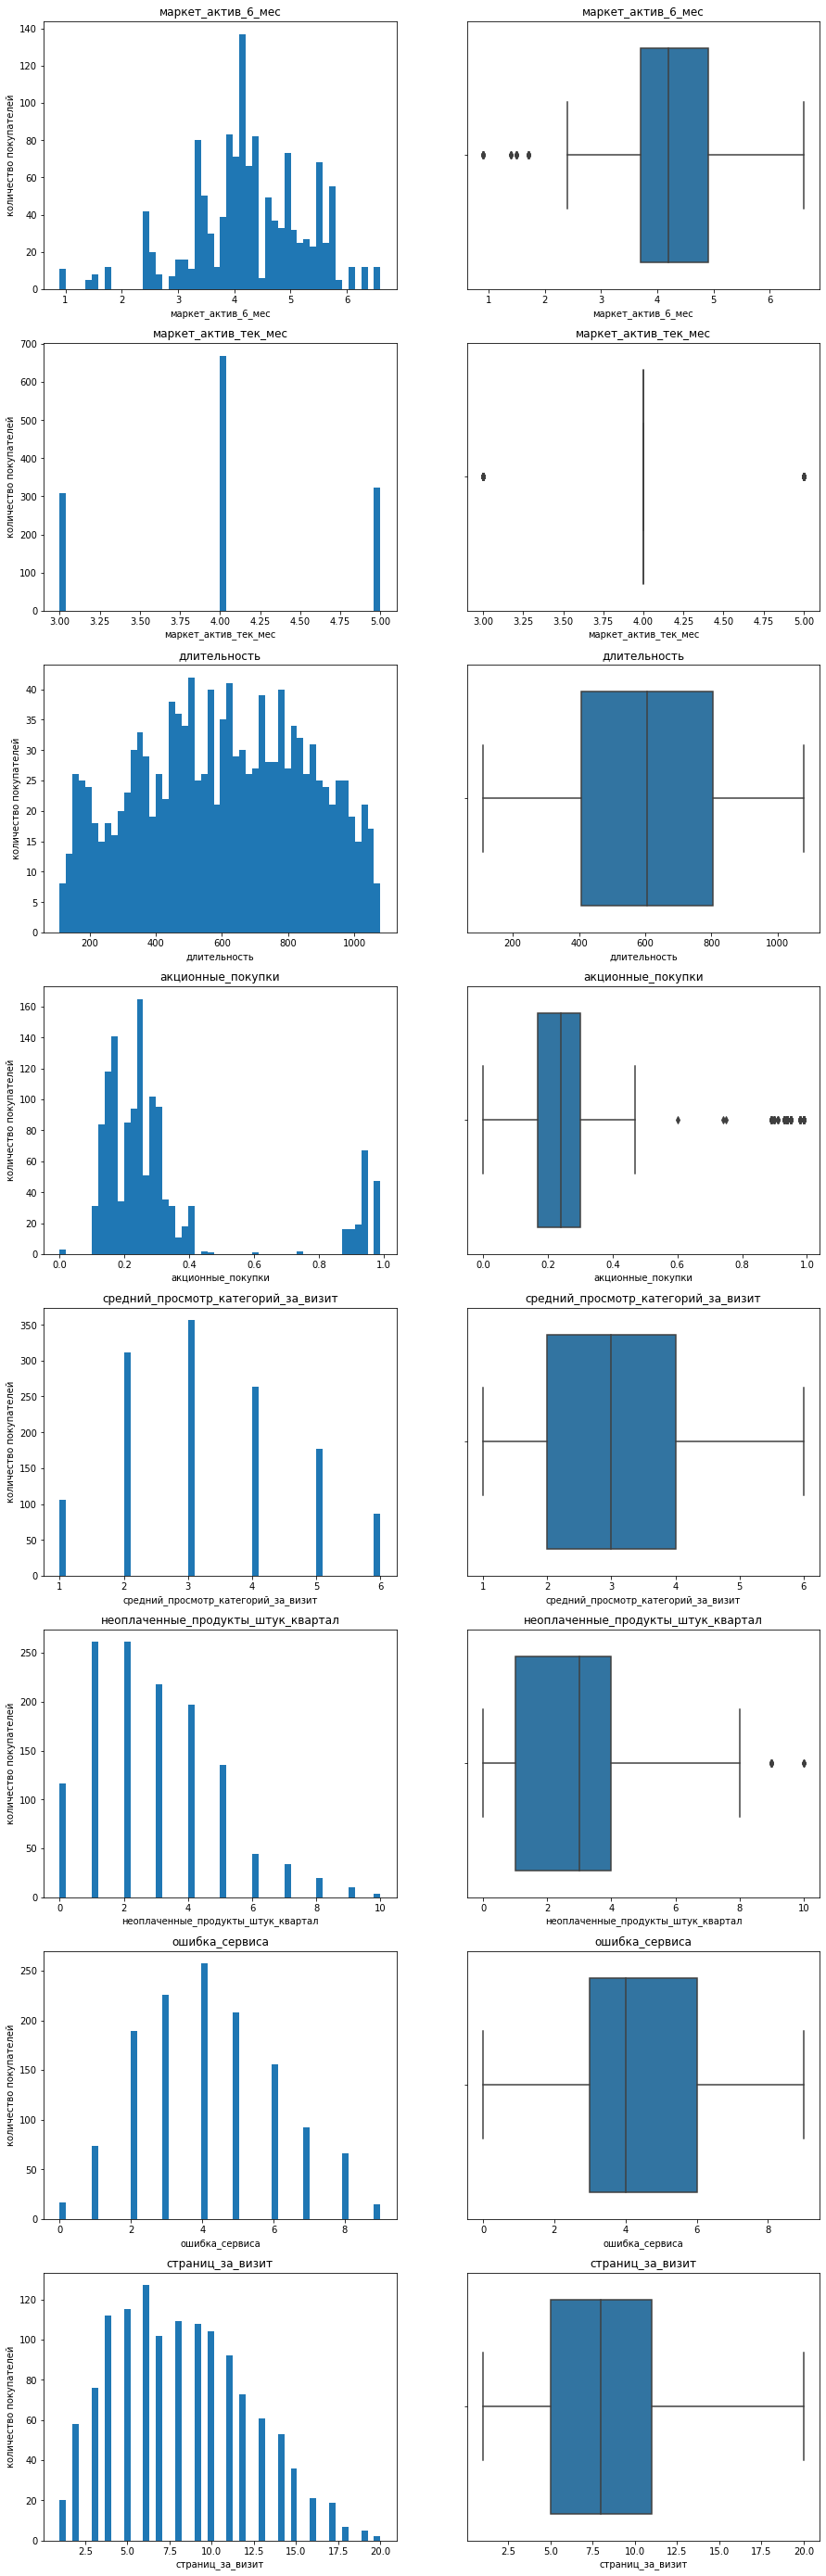

In [ ]:
def issl_analiz(df, x):
    display(df.describe())

    list_col = df.select_dtypes(exclude='object').columns
    if len(list_col)>1:
        fig,axes = plt.subplots(nrows=len(list_col), ncols=2, figsize=(15, x))
        i=0
        for col in list_col:
            df[col].plot(kind='hist', x=col, ax=axes[i][0], title=col, bins=50).set(ylabel='количество покупателей', xlabel=col)
            try:
                sns.boxplot(x=col, data=df, ax=axes[i][1]).set(title=col)
            except:
                df[col].plot(kind='box', ax=axes[i][1], title=col, vert=False, rot=90, ylabel='', xlabel='')
            i+=1
    else:
        fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, x))
        for col in list_col:
            df[col].plot(kind='hist', x=col, ax=axes[0], title=col, bins=50).set(ylabel='количество покупателей', xlabel=col)
            try:
                sns.boxplot(x=col, data=df, ax=axes[1]).set(title=col)
            except:
                df[col].plot(kind='box', ax=axes[1], title=col, vert=False, rot=90, ylabel='', xlabel='')

plt.show()

issl_analiz(market_file.drop('id', axis=1), 50)

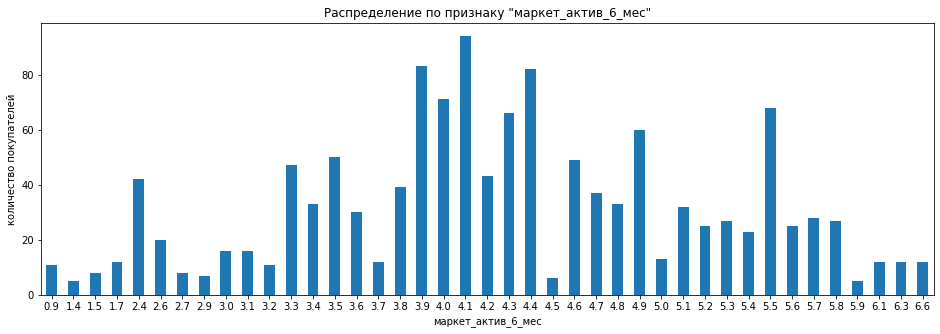

In [ ]:
market_file.pivot_table(index='маркет_актив_6_мес', values='id', aggfunc='count').plot(kind='bar', legend=False, \
                                        xlabel='маркет_актив_6_мес', ylabel='количество покупателей', figsize=(16, 5), \
                                        title='Распределение по признаку "маркет_актив_6_мес"', rot=0);

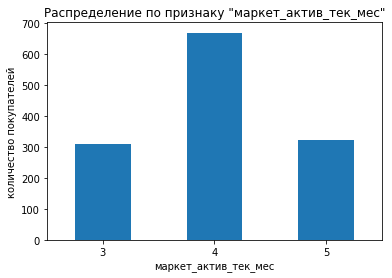

In [ ]:
market_file.pivot_table(index='маркет_актив_тек_мес', values='id', aggfunc='count').plot(kind='bar', legend=False, \
                                        xlabel='маркет_актив_тек_мес', ylabel='количество покупателей', \
                                        title='Распределение по признаку "маркет_актив_тек_мес"', rot=0);

Для количественных признаков датасета `market_file` построены гистограмма и ящик с усами:

- `маркет_актив_6_мес` (какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента за 6 мес.) - распределение очень приблизительно похоже на нормальное (много "дополнительных" пиков и провалов, длинный левый хвост), на большинство клиентов приходилось около 4 коммуникаций (столбчатая диаграмма это подтверждает);
- `маркет_актив_тек_мес` (количество маркетинговых коммуникаций в текущем месяце) - всего 3 уникальных значения (3, 4 и 5), поэтому ящик с усами вообще не получился, дополнительно построена столбчатая диаграмма, которая показывает то же самое, что гистограмма - на большинство клиентов приходилось 4 коммуникации;
- `длительность` (сколько дней прошло с момента регистрации покупателя на сайте) - распределение близко к нормальному, среднестатистический покупатель зарегестрирован около 600 дней;
- `акционные_покупки` (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев) - на гистограмме 2 пика: около 0,3 и около 0,9; почти ни у кого нет доли акционных покупок в диапазоне 0,5-0,8, т.е. люди делятся на любителей акций (без акции почти не покупают - правый пик) и равнодушных к акциям (левый пик - по акции берут редко);
- `средний_просмотр_категорий_за_визит` (показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца) - большинство смотрит 3 категории, а вообще от 1 до 6, и распределение похоже на нормальное, насколько это возможно при всего 6 вариантах показателя;
- `неоплаченные_продукты_штук_квартал` (общее число неоплаченных товаров в корзине за последние 3 месяца) - большинство не оплачивает 1-2 продукта, у распределения длинный правый хвост, т.е. чем больше "забытых" в корзине товаров, тем меньше людей, кто это делает;
- `ошибка_сервиса` (число сбоев, которые коснулись покупателя во время посещения сайта) - нормальное распределение, на большинство приходится 4 сбоя;
- `страниц_за_визит` (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца) - нормальное распределение со сдвигом влево, люди посещают от 1 до 20 страниц сайта за визит, большинство посещает 6 страниц.

### Анализ категориальных признаков для `market_file`

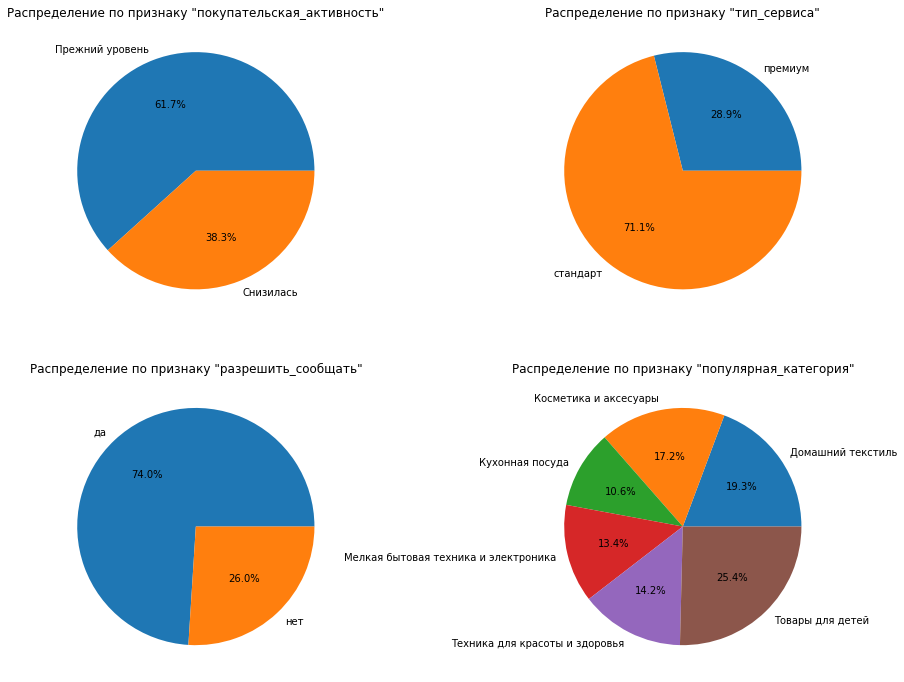

In [ ]:
list_cat = market_file.select_dtypes(include='object').columns

fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
i=0
j=0
for col in list_cat:
    market_file.pivot_table(index=col, aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%', legend=False, \
                    xlabel=col, ylabel='', title=f'Распределение по признаку "{col}"', ax=axes[i][j])
    if j==1:
        j-=1
        i+=1
    else:
        j+=1
plt.show()

Для категориальных признаков датасета `market_file` построены круговые диаграммы:

- `покупательская_активность` (рассчитанный класс покупательской активности - **целевой признак**) - снизилась у 38,3% покупателей;
- `тип_сервиса` (уровень сервиса) - «премиум» у 28,9%, у остальных «стандарт»;
- `разрешить_сообщать` — дали согласие получать дополнительные предложения о товаре 74,0% покупателей;
- `популярная_категория` — самая популярная категория товаров у покупателей за последние 6 месяцев «Товары для детей» (25,4%), самая непопулярная «Кухонная посуда» (10,6%).

### Анализ количественных признаков для `market_money`

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


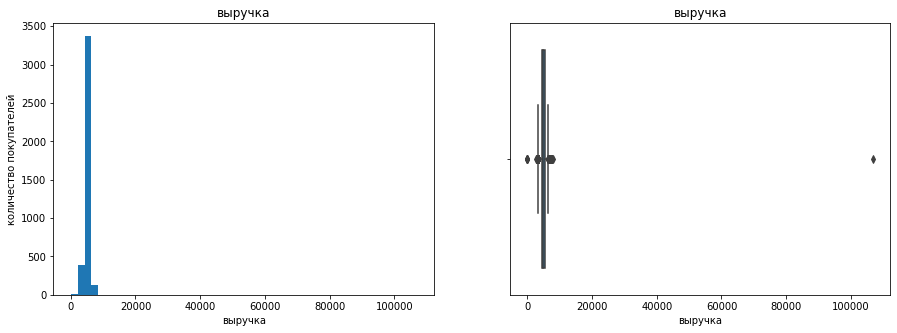

In [ ]:
issl_analiz(market_money.drop('id', axis=1), 5)

В единственном количественном признаке `выручка` очень дальний выброс, действительно это выброс?

In [ ]:
market_money.query('выручка>20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [ ]:
market_file.query('id==215380')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


Этот 1 покупатель зарегистрирован на сайте 637 дней назад, его любимая категория товаров «Техника для красоты и здоровья». Возможно, это и не ошибка в данных, а действительно человек купил что-то дорогостоящее. Посмотрим распределение без него:

,выручка
count,3899.00000
mean,4999.57743
std,706.99988
min,0.00000
25%,4590.10000
50%,4957.00000
75%,5363.00000
max,7799.40000


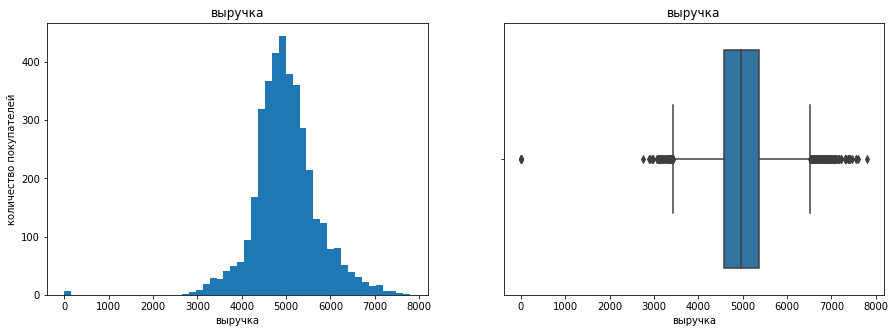

In [ ]:
issl_analiz(market_money.drop('id', axis=1).query('выручка<20000'), 5)

Получилось нормальное распределение, не считая тех, кто ничего не купил (выручка=0):

In [ ]:
market_money.query('выручка==0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Все нули в выручке за предыдущие 2 месяца, т.е. в текущем месяце они что-то купили (не выбросы).

### Анализ количественных признаков для `market_time`

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


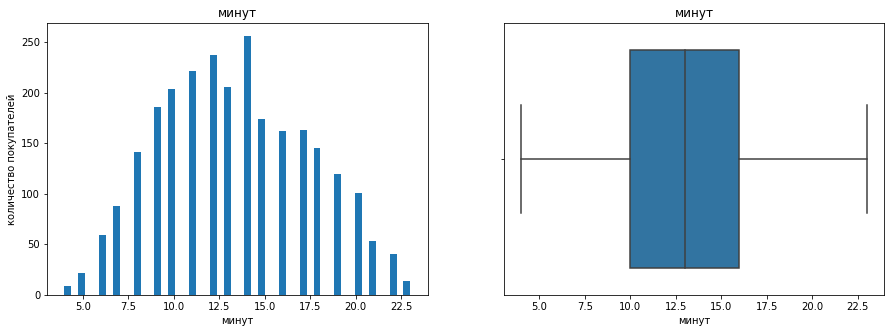

In [ ]:
issl_analiz(market_time.drop('id', axis=1), 5)

Количество минут, проведённых пользователями на сайте, нормально распределено, проводят от 4 до 23 минут (в месяц - предыдущий или текущий), большинство 13 минут.

### Анализ категориальных признаков для `market_time` и `market_money`

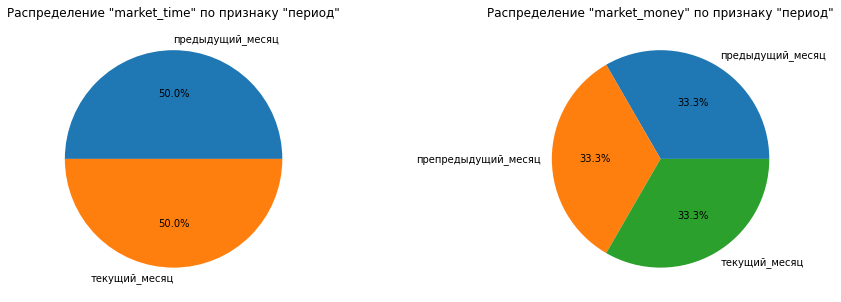

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
market_time.pivot_table(index='период', aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%', legend=False, \
                    ylabel='', title='Распределение "market_time" по признаку "период"', ax=axes[0])
market_money.pivot_table(index='период', aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%', legend=False, \
                    ylabel='', title='Распределение "market_money" по признаку "период"', ax=axes[1]);

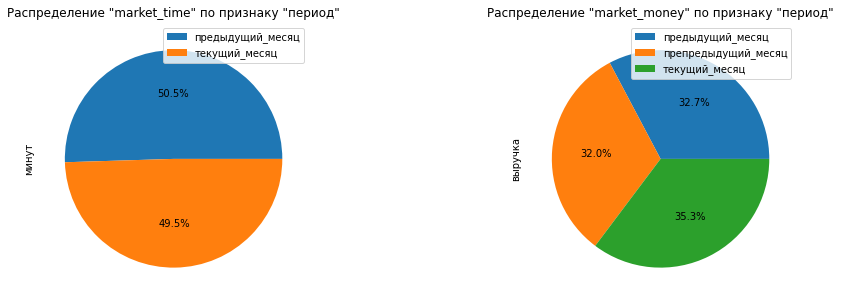

In [ ]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
market_time.pivot_table(index='период', aggfunc='sum').plot(kind='pie', y='минут', autopct='%1.1f%%', legend=True, \
                    labels=None, ylabel='минут', title='Распределение "market_time" по признаку "период"', ax=axes[0])
market_money.pivot_table(index='период', aggfunc='sum').plot(kind='pie', y='выручка', autopct='%1.1f%%', legend=True, \
                    labels=None, ylabel='выручка', title='Распределение "market_money" по признаку "период"', ax=axes[1]);

Распределение клиентов по количеству показывает, что в датасете `market_time` каждый id встречается 2 раза - в предыдущем месяце и в текущем. В датасете `market_money` - каждый 3 раза: в препредыдущем месяце, в предыдущем и в текущем. Подтверждается то, что было видно ещё при загрузке данных.

Время в минутах распределено по периодам тоже примерно пополам: 49,5% в текущем месяце.

32% выручки приходится на препредыдущий месяц, 32,7% на предыдущий и 35,3% на текущий месяц (примерно равномерно, выручка слегка растёт).

### Анализ количественных признаков для `money`

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


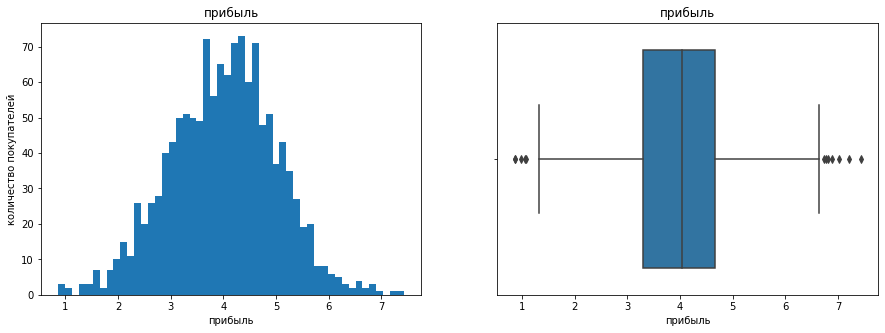

In [ ]:
issl_analiz(money.drop('id', axis=1), 5)

Прибыль распределена нормально, 1 покупатель за 3 месяца приносит от 0,86 до 7,43 (видимо, тыс. рублей), большинство около 4.

### Отберём клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период:

In [ ]:
market_money.pivot_table(index='id', values='выручка', aggfunc='sum').query('выручка>0')

,выручка
id,
215348,3293.1
215349,14659.6
215350,15341.9
215351,17561.4
215352,16274.0
...,...
216643,13109.7
216644,15381.0
216645,15633.2


In [ ]:
market_money.query('выручка>0').groupby('id').agg({'период':'count', 'выручка':'sum'}).query('период==3')

,период,выручка
id,,
215349,3,14659.6
215350,3,15341.9
215351,3,17561.4
215352,3,16274.0
215353,3,15251.0
...,...,...
216643,3,13109.7
216644,3,15381.0
216645,3,15633.2


За последние 3 месяца что-то покупали абсолютно все, но не все каждый месяц: ежемесячно совершали покупки 1297 человек из 1300. Три id без покупок мы видели в п.3.3 (они что-то купили в текущем месяце, возможно недавно только зарегистрировались).

**Вывод:** удаляем 1 выброс с аномальной выручкой и тех трёх, которые совершали покупки не каждый месяц, других аномалий не обнаружено. Будет 1296 покупателей.

## Объединение таблиц

### Объединим таблицы `market_file.csv`, `market_money.csv`, `market_time.csv`. Данные о прибыли из файла `money.csv` при моделировании не понадобятся.

### Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

Сделали пункты 4.1 и 4.2 сразу, получился датафрейм с 5 новыми колонками (3 с выручкой по периодам и 2 с минутами на сайте по периодам) и всё теми же 1300 покупателями.

In [ ]:
mm_pivot = market_money.pivot_table(index='id', columns='период', values='выручка')
mm_pivot.columns = [f'выручка_{col}' for col in mm_pivot.columns]

mt_pivot = market_time.pivot_table(index='id', columns='период', values='минут')
mt_pivot.columns = [f'минут_{col}' for col in mt_pivot.columns]

market_file1 = market_file.merge(mm_pivot, on='id', how='left').merge(mt_pivot, on='id', how='left')
market_file1 = market_file1.query('id!=215380').query('id!=215348').query('id!=215357').query('id!=215359')
#удаление 1 выброса с аномальной выручкой и 3 клиентов с 0 пред.мес.

dfinfo(market_file1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## Корреляционный анализ

Проведём корреляционный анализ признаков в **количественной шкале** в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

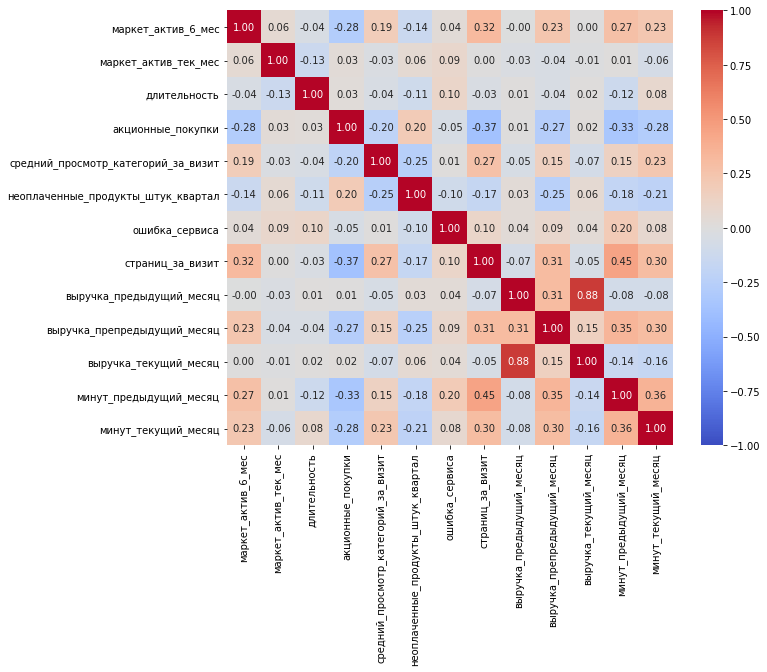

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(market_file1.drop('id', axis=1).corr(method='spearman'), annot=True, cmap='coolwarm', vmin=-1, fmt='.2f')
plt.show()

**Вывод:** Между входными количественными признаками нет корреляции с коэффициентом от 0,9 и выше (который считается признаком мультиколинеарности), максимальный 0,88 между выручкой текущего и предыдущего месяцев (связь сильная, почти мультиколинеарность). Больше сильных связей между количественными признаками нет. Слабая прямая связь у времени на сайте в предыдущем месяце и количеством посещённых страниц за визит (0,45), остальные коэффициенты корреляции ещё меньше, т.е. остальные признаки связаны между собой слабо или никак.

## Использование пайплайнов

### Во время подготовки данных используем ColumnTransformer.

Количественные и категориальные признаки обработаем в пайплайне раздельно.

Для кодирования категориальных признаков используем два кодировщика: OneHotEncoder и OrdinalEncoder, для масштабирования количественных — два скейлера: StandardScaler и MinMaxScaler.

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = market_file1.drop(['id', 'покупательская_активность'], axis=1)
y = market_file1['покупательская_активность']

cat_columns = X.select_dtypes(include='object').columns
num_columns = X.select_dtypes(exclude='object').columns

print('Категориальные признаки:', cat_columns)
print('Количественные признаки:', num_columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y
)

Категориальные признаки: Index(['тип_сервиса', 'разрешить_сообщать', 'популярная_категория'], dtype='object')
Количественные признаки: Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц'],
      dtype='object')


In [ ]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))#, sparse=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns.drop('популярная_категория')),
        ('ord', ord_pipe, ['популярная_категория']),
        ('num', StandardScaler(), num_columns),
        ('num2', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['тип_сервиса', 'разрешить_сообщать'], dtype='object')),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequen...
                                ('num2', MinMaxScaler(),
                                 Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц'],
      dtype='object'))])

### Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберём как минимум один гиперпараметр. Выберем подходящую для задачи метрику, используем эту метрику при подборе гиперпараметров.

**Выбор метрики:** нам важно правильно предсказать снижение покупательской активности. Если модель предскажет снижение, а покупатель не собирался меньше покупать, то для этого покупателя будут зря проведены какие-то маркетинговые мероприятия (возможно, он воспримет их как то, что сервис магазина вдруг стал более навязчивым, и пойдёт за покупками на другие сайты). Если модель предскажет прежний уровень покупок, а на самом деле активность снизится, магазин недополучит прибыль. Целевой признак бинарный (либо снизится, либо нет). Используем метрику ROC-AUC, т.к. нам важно поменьше ошибок как 1 рода, так и 2-го.

In [ ]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,6),
        'models__max_features': range(2,6),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear'
        )],
        'models__C': range(1,5),
        'models__penalty': ['l1', 'l2'],
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC() с полиномиальным ядром
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True,
            kernel='poly'
        )],
        'models__degree': range(1,6),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC() с линейным ядром
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print('Метрика ROC-AUC для лучшей модели:', grid.best_score_)

Метрика ROC-AUC для лучшей модели: 0.9130710594892413


### Выберем лучшую модель, используя заданную метрику.

Для этого применим стратегию:

- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт лучшую модель.

In [ ]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['тип_сервиса', 'разрешить_сообщать'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   Simp...
  

Использован один общий пайплайн для всех 4 моделей, вместе с подбором гиперпараметров для каждой модели (п.6.2), выбрана метрика ROC-AUC.

**Лучшая модель** - SVC с линейным ядром, значение метрики ROC-AUC 0,913 (довольно высокое значение, модель-победитель должна предсказывать почти точно).

ROC-AUC на тестовой выборке: 0.9162722970513287


test    26
pred    26
dtype: int64

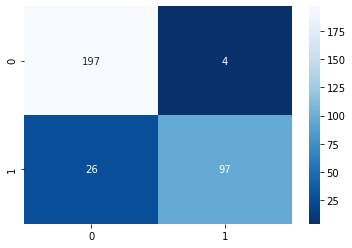

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
preds = grid.best_estimator_.predict_proba(X_test)
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, preds[:,1]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

sravnilka = pd.DataFrame(zip(y_test, y_pred), columns = ['test','pred'])
sravnilka.query('test!=pred & test=="Снизилась"').count()
#pd.Series(y_pred).value_counts()

Получается класс 0 - прежний уровень покупательской активности, класс 1 - активность снизилась.
Лучшая модель допускает 4 ошибки 1 рода (предсказывает ложное снижение) и 26 ошибок 2 рода (не предсказала снижение там, где оно должно быть). Многовато ошибок 2 рода.

ROC-AUC на тестовой выборке 0.916, больше чем на тренировочной.

## Анализ важности признаков

### Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.

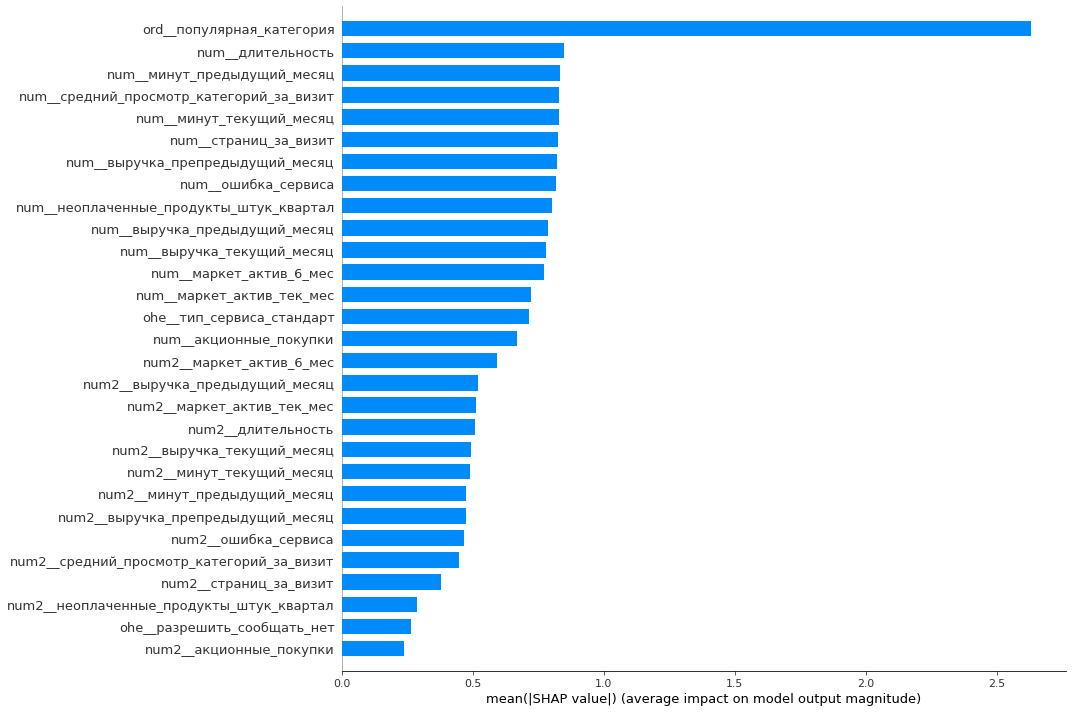

In [ ]:
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)
best_model = grid.best_estimator_['models'].fit(X_encoded, y_train)
explainer = shap.PermutationExplainer(best_model, X_encoded)
shap.summary_plot(X_encoded, plot_type='bar', feature_names=grid.best_estimator_[:-1].get_feature_names_out(),
                  max_display=40, plot_size=(15, 10))

### Выводы о значимости признаков:

- какие признаки сильнее всего влияют на целевой признак?

Популярная категория, закодированная OrdinalEncoder, самый влиятельный признак (с большим отрывом).

- какие признаки мало значимы для модели?

Масштабированные MinMaxScaler доля акционных покупок и количество неоплаченных покупок, закодированное OneHotEncoder разрешить_сообщать - наименее значимые признаки.

- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?

Чтобы использовать только значимые признаки, можно:

- большинство значимых количественных признаков закодированы StandardScaler, а малозначимых количественных - MinMaxScaler, можно количественные кодировать только StandardScaler.

Если какие-то признаки после любой обработки попадают в малозначимые, можно их вообще удалить из выборки и не обучать на них модель.

## Сегментация покупателей

### Возьмём сегмент "Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью"

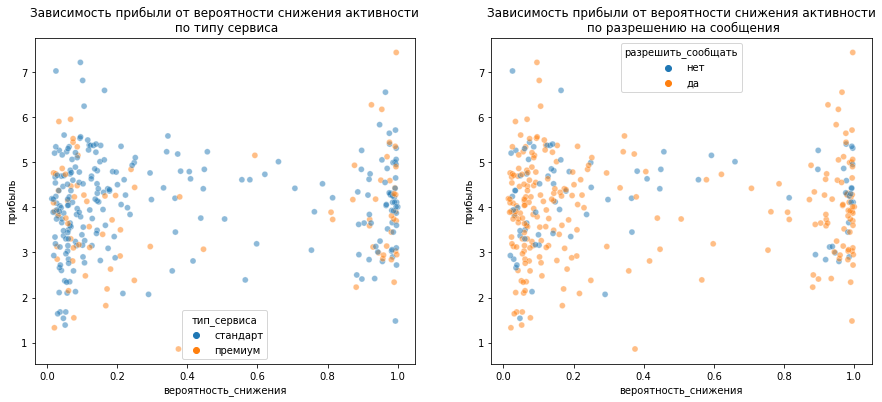

In [ ]:
sravnilka['nomer'] = pd.DataFrame(y_test).index
sravnilka = sravnilka.set_index('nomer')
sravnilka['вероятность_снижения'] = preds[:,1]

segm = market_file1.copy()
segm = segm.merge(money, on='id', how='left')

segm['nomer'] = segm.index
segm = segm.set_index('nomer')

segm = sravnilka.join(segm, on='nomer', how='left')

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.scatterplot(data=segm, x='вероятность_снижения', y='прибыль', hue='тип_сервиса', alpha=0.5,
                ax=axes[0]).set(title='Зависимость прибыли от вероятности снижения активности\n по типу сервиса')
sns.scatterplot(data=segm, x='вероятность_снижения', y='прибыль', hue='разрешить_сообщать', alpha=0.5,
                ax=axes[1]).set(title='Зависимость прибыли от вероятности снижения активности\n по разрешению на сообщения')

plt.show()

Возьмём тех, для кого модель предсказала снижение покупательской активности с вероятностью выше 0.8 (скопление точек на графиках справа) и кто приносит магазину прибыль выше 2.5 (ниже 2.5 вообще мало точек, а справа, где большая вероятность снижения активности, ещё меньше).

Разбивка на категориальные признаки ничего нам не дала, кроме того, что "премиумов" модель отсортировала с меньшими сомнениями - оранжевых точек в середине первого графика почти нет.

Посмотрим зависимость прибыли от полученной вероятности в разбивке по популярным категориям покупок, а ещё зависимость вероятности снижения активности покупателей от выручки за последние 3 месяца и от времени на сайте за последние 2 месяца, от доли покупок по акции и давности регистрации на сайте:

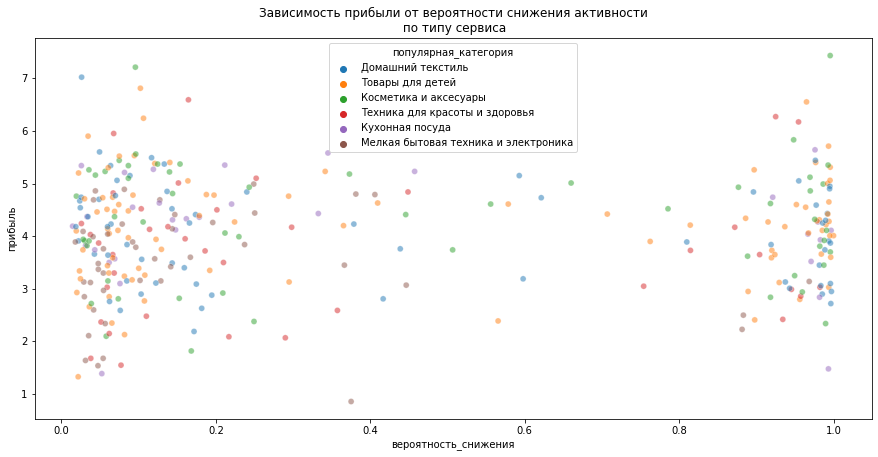

In [ ]:
plt.figure(figsize=(15, 7))

sns.scatterplot(data=segm, x='вероятность_снижения', y='прибыль', hue='популярная_категория', alpha=0.5)\
.set(title='Зависимость прибыли от вероятности снижения активности\n по типу сервиса');

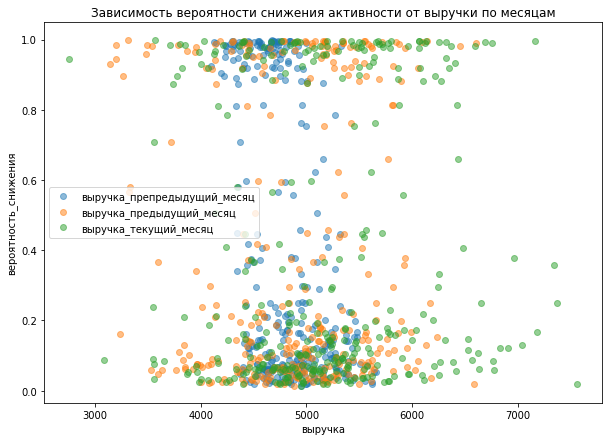

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(segm['выручка_препредыдущий_месяц'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='',
             label='выручка_препредыдущий_месяц')
plt.plot(segm['выручка_предыдущий_месяц'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='',
             label='выручка_предыдущий_месяц')
plt.plot(segm['выручка_текущий_месяц'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='',
             label='выручка_текущий_месяц')
plt.title('Зависимость вероятности снижения активности от выручки по месяцам')
plt.legend(loc='center left')
plt.xlabel('выручка')
plt.ylabel('вероятность_снижения')

plt.show()

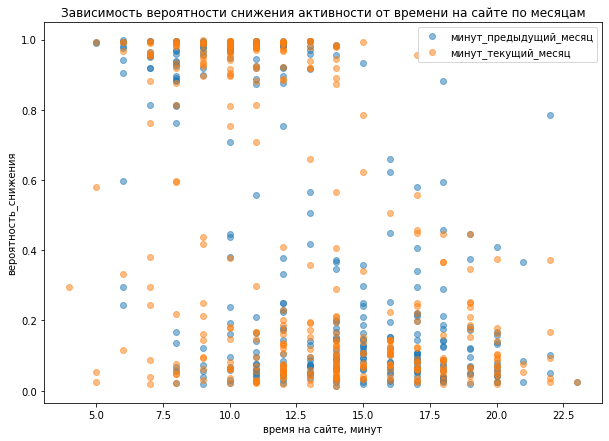

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(segm['минут_предыдущий_месяц'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='',
             label='минут_предыдущий_месяц')
plt.plot(segm['минут_текущий_месяц'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='',
             label='минут_текущий_месяц')
plt.title('Зависимость вероятности снижения активности от времени на сайте по месяцам')
plt.legend(loc='best')
plt.xlabel('время на сайте, минут')
plt.ylabel('вероятность_снижения')

plt.show()

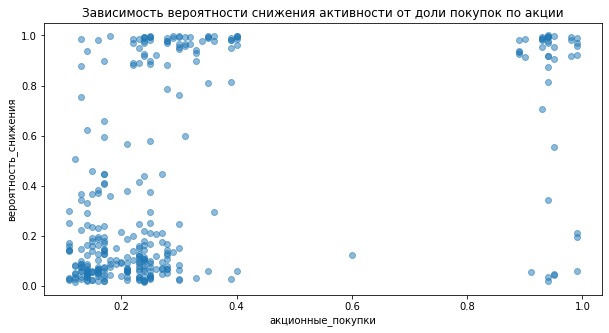

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(segm['акционные_покупки'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='')

plt.title('Зависимость вероятности снижения активности от доли покупок по акции')
plt.xlabel('акционные_покупки')
plt.ylabel('вероятность_снижения')

plt.show()

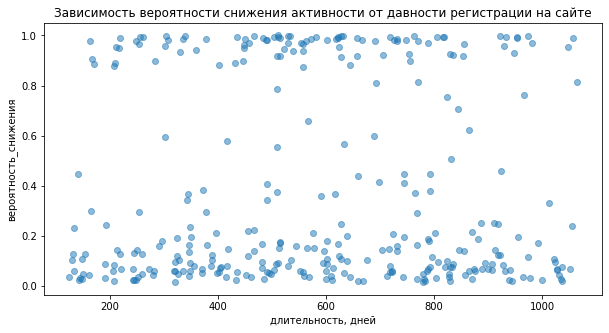

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(segm['длительность'], segm['вероятность_снижения'], alpha=0.5, marker='o', linestyle='')

plt.title('Зависимость вероятности снижения активности от давности регистрации на сайте')
plt.xlabel('длительность, дней')
plt.ylabel('вероятность_снижения')

plt.show()

В графике зависимости вероятности снижения от выручки по месяцам заметно, что вверху графика (где высокая вероятность) больше доля синих точек - выручки 2 месяцев назад (логично, кто-то 2 месяца не покупал, вот и снизилась активность).

В графике зависимости вероятности снижения от доли покупок по акции заметно, что большинство точек там, где вероятность снижения  активности низкая и доля покупок по акции тоже низкая. Мало точек там, где низкая вероятность снижения и высокая доля покупок по акции. Возможно, проведение акций увеличит активность покупателей.

Больше чётких зависимостей не видно.

Итак, возьмём тех, для кого модель предсказала снижение покупательской активности с вероятностью выше 0.8 и кто приносит магазину прибыль выше 2.5.

In [ ]:
segm = segm.query('вероятность_снижения>0.8 & прибыль>2.5').sort_values(by='прибыль', ascending=False)
dfinfo(segm)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 49 to 322
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   test                                 89 non-null     object 
 1   pred                                 89 non-null     object 
 2   вероятность_снижения                 89 non-null     float64
 3   id                                   89 non-null     float64
 4   покупательская_активность            89 non-null     object 
 5   тип_сервиса                          89 non-null     object 
 6   разрешить_сообщать                   89 non-null     object 
 7   маркет_актив_6_мес                   89 non-null     float64
 8   маркет_актив_тек_мес                 89 non-null     float64
 9   длительность                         89 non-null     float64
 10  акционные_покупки                    89 non-null     float64
 11  популярная_категория            

,test,pred,вероятность_снижения,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,...,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль
nomer,,,,,,,,,,,,,,,,,,,,,
49,Снизилась,Снизилась,0.995639,215401.0,Снизилась,премиум,да,3.4,5.0,339.0,...,2.0,3.0,3.0,4.0,5548.5,4833.0,6065.9,10.0,8.0,7.43
153,Снизилась,Снизилась,0.965003,215505.0,Снизилась,стандарт,да,4.4,4.0,254.0,...,2.0,3.0,5.0,3.0,3951.0,4698.0,3982.2,7.0,7.0,6.55
17,Снизилась,Снизилась,0.925076,215368.0,Снизилась,премиум,да,3.8,5.0,829.0,...,2.0,2.0,6.0,1.0,5823.0,4536.0,5591.6,11.0,9.0,6.27
397,Снизилась,Снизилась,0.954662,215749.0,Прежний уровень,премиум,да,5.8,5.0,624.0,...,4.0,3.0,6.0,14.0,5190.0,4928.0,5092.5,14.0,17.0,6.17
104,Снизилась,Снизилась,0.948348,215456.0,Снизилась,стандарт,да,1.7,4.0,449.0,...,3.0,4.0,4.0,5.0,5134.5,4353.0,6318.8,10.0,9.0,5.83


### Графическое исследование выбранного сегмента, предложения по работе с сегментом для увеличения покупательской активности.

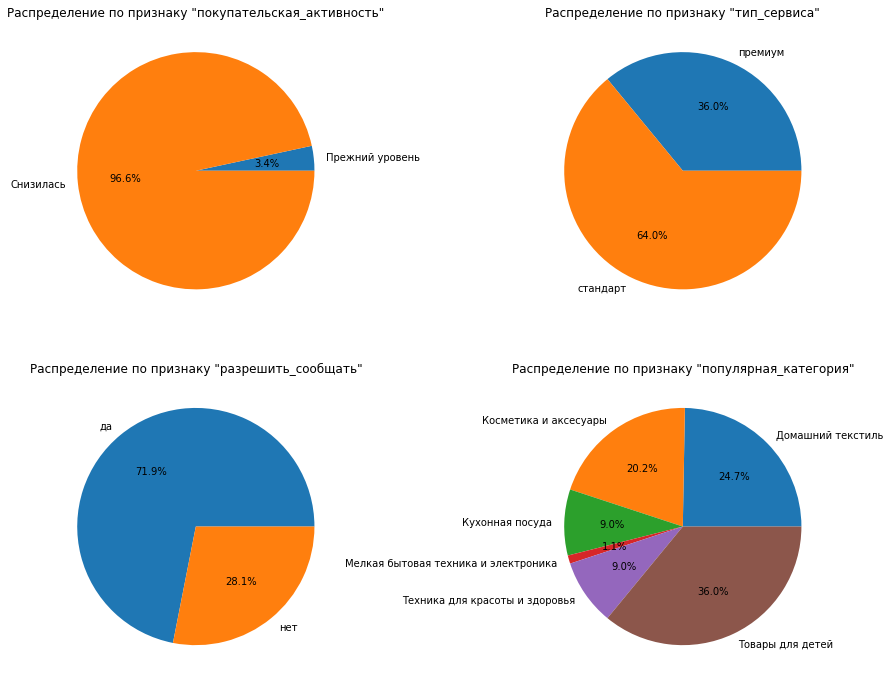

In [ ]:
list_cat1 = segm.drop(['test', 'pred'], axis=1).select_dtypes(include='object').columns

fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
i=0
j=0
for col in list_cat1:
    segm.pivot_table(index=col, aggfunc='count').plot(kind='pie', y='id', autopct='%1.1f%%', legend=False, \
                    xlabel=col, ylabel='', title=f'Распределение по признаку "{col}"', ax=axes[i][j])
    if j==1:
        j-=1
        i+=1
    else:
        j+=1
plt.show()

На диаграммах видно:

- покупательская активность в реальности снизилась почти у всех (в этом сегменте модель угадала 96,6%),
- премиум-сервис у 36% клиентов (мы не знаем, какие преимущества даёт статус премиум, но если это выгодно магазину, можно подумать, как это сделать выгодно и покупателю тоже, и предложить "стандартам" перейти на "премиум"),
- 71,9% разрешили сообщать им о новинках, акциях и т.п., возможно стоит ещё повысить этот процент, например, предложить специальную акцию для согласных подписаться на рассылку,
- среди сегмента популярны покупки в категориях "Домашний текстиль" и "Товары для детей" (чуть больше половины всех покупок), менее популярны "Косметика и аксессуары". Товары для детей и косметика покупаются довольно часто, как "расходники", т.е. товары не длительного пользования. Можно придумать акции, где приобретение одновременно больше 1 "любимой" категории будет выгодно покупателю (и магазину тоже).

### Выводы о сегментах:

- какой сегмент взяли для дополнительного исследования?

Группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью (потеря таких клиентов снизит прибыли магазина).

- какие предложения вы сделали и почему?

Попробовать повысить активность этих покупателей при помощи акций, персональных предложений, которые были бы им выгодны (покупки по акции для нескольких категорий товара сразу, переход на премиум, согласие на рассылку ради полезных новостей магазина). Можно дарить премиум-подписку тем, кто купит несколько товаров сразу, или регулярно покупает 3 месяца подряд свыше какой-то суммы. Возможно, такие персонализованные предложения заинтересуют покупателя, и его активность в магазине не снизится.

## Общий вывод

- **Задача** - предсказать при помощи разработанной модели снижение покупательской активности в следующие 3 месяца и предложить способы избежать этого снижения.


- **Исходные данные и проведённая предобработка**:

В датасете `market_file` 1300 строк (покупателей) с данными о покупательской активности, проведённых маркетинговых действиях, часто покупаемых категориях товаров, доле покупок по акции, визитах на сайт и их длительности, давности регистрации на сайте, сбоях в работе сайта, неоплаченных покупках в корзине.

В `money` данные о прибыли для каждого из них (тоже 1300 строк).

В `market_money` помесячные данные о выручке за последние 3 месяца (3900 строк - 3 месяца на каждого покупателя).

В `market_time` помесячные данные о времени на сайте за последние 2 месяца (2600 строк - 2 месяца на каждого покупателя).

Пропусков и неявных дубликатов нет, привели названия столбцов к единому виду (нижний регистр со знаком _ вместо пробела) и устранили неявные дубликаты и исправили опечатки. Удалили аномалию в выручке, отобрали клиентов, делавших покупки 3 месяца подряд. Для подбора модели создана общая таблица со всеми признаками из 3 датасетов (кроме money).

- **Что сделано для поиска лучшей модели:**

Создан общий пайплайн, где числовые данные из общей таблицы масштабированы 2 скейлерами, категориальные кодированы 2 кодировщиками, на полученном результате обучены 4 модели с подбором всех вариантов выбранных гиперпараметров (по 1-2 для каждой модели).

- **Лучшая модель** - SVC с линейным ядром, её метрика ROC-AUC 0.913, на тестовой выборке 0.916


- **Выводы и дополнительные предложения для выбранного сегмента покупателей**:

Для группы клиентов с высокой (предсказанной лучшей моделью выше 0.8) вероятностью снижения покупательской активности и высокой прибыльностью (выше 2.5) предлагается провести акции по вручению наиболее стабильным покупателям премиум-статуса, стимулировать покупки одновременно в нескольких категориях товаров, сделать персональные предложения, которые были бы выгодны этим покупателям, чтобы магазин не терял прибыльных клиентов.